# Collaboration and Competition

### Starting the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from collections import deque

import numpy as np
import matplotlib.pyplot as plt
import torch

from unityagents import UnityEnvironment
from ddpg_agent import Agent

Algorithm will train with GPU


Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

In [2]:
env = UnityEnvironment(file_name="Tennis/Tennis.exe")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])
print('The state for the second agent looks like:', states[1])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]
The state for the second agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.4669857  -1.5
  0.          0.         -6.83172083  6.          0.          0.        ]


In [5]:
agent = Agent(state_size=state_size, action_size=action_size, random_seed=7)

In [6]:
def train(n_episodes=5000, max_t=1000, print_every=100):
    scores_deque = deque(maxlen=100)
    average_scores = []
    scores_episode = []
    solved = False
    best_average_score = -1
    episode_best_average_score = -1
    last_episode = -1
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        states = env_info.vector_observations
        agent.reset()
        scores = np.zeros(num_agents)
        for t in range(max_t):
            actions = agent.act(states, add_noise=True)
            env_info = env.step(actions)[brain_name]
            next_states = env_info.vector_observations
            rewards = env_info.rewards
            dones = env_info.local_done
            for state, action, reward, next_state, done in zip(states, actions, rewards, next_states, dones):
                agent.step(state, action, reward, next_state, done, t)
            states = next_states
            scores += rewards
            if np.any(done):
                break
        score = np.max(scores)
        scores_episode.append(score)
        scores_deque.append(score)
        
        average_score = np.mean(scores_deque)
        average_scores.append(np.mean(scores_deque))
        print('\rEpisode {}\tScore : {:.3f}\tAverage Score: {:.3f}'.format(i_episode, score, average_score), end="")
        
        if i_episode % print_every == 0:
            torch.save(agent.actor_local.state_dict(), 'models/checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'models/checkpoint_critic.pth')
            print('\rEpisode {}\tScore : {:.3f}\tAverage Score: {:.3f}'.format(i_episode, score, average_score))
        
        if i_episode >= 100 and average_score >= 0.5 and not solved:
            solved = True
            best_average_score = average_score
            episode_best_average_score = i_episode
            
            print("\n\nEnviroment solved in {} episodes!".format(i_episode))
            
            last_episode = i_episode + 500
            print("Continuing training for more 500 episodes (until episode {}) to see if we can still improve average score!\n".format(last_episode))
            
            torch.save(agent.actor_local.state_dict(), 'models/best_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'models/best_critic.pth')
            
        if solved and average_score > best_average_score:
            episode_best_average_score = i_episode
            best_average_score = average_score
            
            torch.save(agent.actor_local.state_dict(), 'models/best_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'models/best_critic.pth')
        
        if solved and i_episode == last_episode:
            break
            
    print("Training done!")
    print("Best average score: {:.3f}".format(best_average_score))
    print("Episode with best average score: {}".format(episode_best_average_score))
    
    return average_scores, scores_episode

In [7]:
average_scores, scores_episode = train()

Episode 100	Score : 0.000	Average Score: 0.006
Episode 200	Score : 0.000	Average Score: 0.007
Episode 300	Score : 0.000	Average Score: 0.041
Episode 400	Score : 0.200	Average Score: 0.066
Episode 500	Score : 0.000	Average Score: 0.068
Episode 600	Score : 0.000	Average Score: 0.056
Episode 700	Score : 0.200	Average Score: 0.043
Episode 800	Score : 0.100	Average Score: 0.049
Episode 900	Score : 0.000	Average Score: 0.053
Episode 1000	Score : 0.090	Average Score: 0.051
Episode 1100	Score : 0.200	Average Score: 0.043
Episode 1200	Score : 0.100	Average Score: 0.044
Episode 1300	Score : 0.090	Average Score: 0.067
Episode 1400	Score : 0.100	Average Score: 0.062
Episode 1500	Score : 0.000	Average Score: 0.060
Episode 1600	Score : 0.100	Average Score: 0.092
Episode 1700	Score : 0.100	Average Score: 0.092
Episode 1800	Score : 0.000	Average Score: 0.103
Episode 1900	Score : 0.100	Average Score: 0.109
Episode 2000	Score : 0.090	Average Score: 0.483
Episode 2002	Score : 2.700	Average Score: 0.509



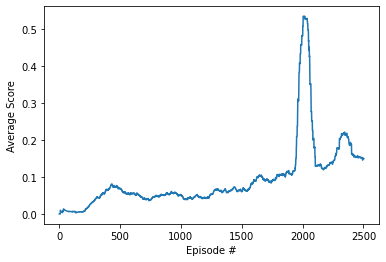

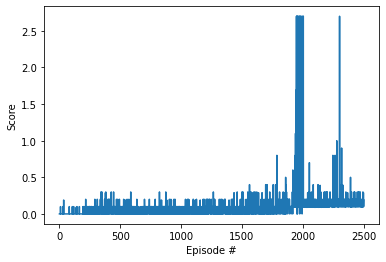

In [8]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(average_scores)+1), average_scores)
plt.ylabel('Average Score')
plt.xlabel('Episode #')
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores_episode)+1), scores_episode)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [9]:
env.close()